In [52]:
import numpy as np
import pandas as pd
from lstm_functions import *
from lost_functions import *
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf

# <a id='toc1_'></a>[This to try to tune and try to get a good prediction for Apple Stock](#toc0_)
If i can get a good prediction for Apple Stock, then i can use the same model for other stocks  
This notebook is mainly to tune the model and get a good prediction for Apple Stock

# <a id='toc2_'></a>[Reading and storing the Data](#toc0_)

In [53]:
xls = pd.ExcelFile('data/data_for_testing.xlsx')
all_data = {}
# This is too much data to load into memory at once
# for sheet in xls.sheet_names:
#     all_data[sheet] = pd.read_excel(xls, sheet_name=sheet)
for sheet in ["AAPL"]:
    data = pd.read_excel(xls, sheet_name=sheet).set_index('Date')
    # Resample to monthly data as a simple way to reduce the number of data points
    # Daily data is too much and take too long to train
    new_data = data.resample('M').last().reset_index()
    # new_data = new_data[new_data['Date'] < '2019-12-01']
    all_data[sheet] = new_data

In [54]:
all_data["AAPL"].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Sector',
       'Ticker'],
      dtype='object')

<Axes: >

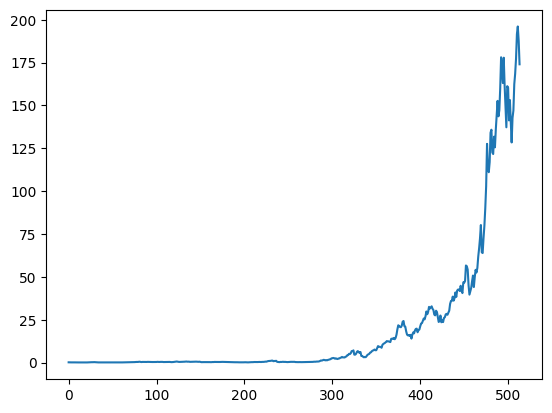

In [55]:
all_data["AAPL"]["Open"].plot()

In [56]:
final_importance_values = {}
final_predictions = {}
# 30 is not a good number of batches, but it's a start for testing
# 60 is a good number of batches, but it takes a long time to train
time_steps = 12
features = 6

In [57]:
def evaluate_model(y_train, train_predictions, y_test, test_predictions, ticker, feature):
    train_mae = mean_absolute_error(y_train, train_predictions)
    test_mae = mean_absolute_error(y_test, test_predictions)

    train_rmse = mean_squared_error(y_train, train_predictions, squared=False)
    test_rmse = mean_squared_error(y_test, test_predictions, squared=False)

    print(f"\nEvaluation for {ticker} on {feature}:")
    print(f"Training MAE: {train_mae}, Testing MAE: {test_mae}")
    print(f"Training RMSE: {train_rmse}, Testing RMSE: {test_rmse}\n")
    return train_mae, test_mae, train_rmse, test_rmse


In [58]:
def plot_predictions(y_train, train_predictions, y_test, test_predictions, ticker, feature):
    plt.figure(figsize=(14,7))
    plt.plot(y_train, label="Actual Train Values", color='blue')
    plt.plot(train_predictions, label="Predicted Train Values", color='blue', linestyle='dashed')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label="Actual Test Values", color='red')
    plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), test_predictions, label="Predicted Test Values", color='red', linestyle='dashed')
    plt.title(f"{ticker} {feature} - Actual vs Predicted Values")
    plt.legend()
    plt.show()


451 51

Working on: AAPL


2023-09-21 11:14:53.505289: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-09-21 11:14:57.994807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 128ms/step
Predicted value for AAPL: [ 1.2163395e+02  1.3229443e+02  1.6007982e+02  1.7978258e+02
  1.6037697e+02 -2.1153059e+09]
Importance value for AAPL: -0.3126019835472107
 1/15 [=>............................] - ETA: 0s

2023-09-21 11:25:45.162736: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2/2 [==============================] - 0s 55ms/step

Evaluation for AAPL on Open:
Training MAE: 0.9271098523093034, Testing MAE: 40.5348565344717
Training RMSE: 2.139178396505041, Testing RMSE: 44.49680306562039



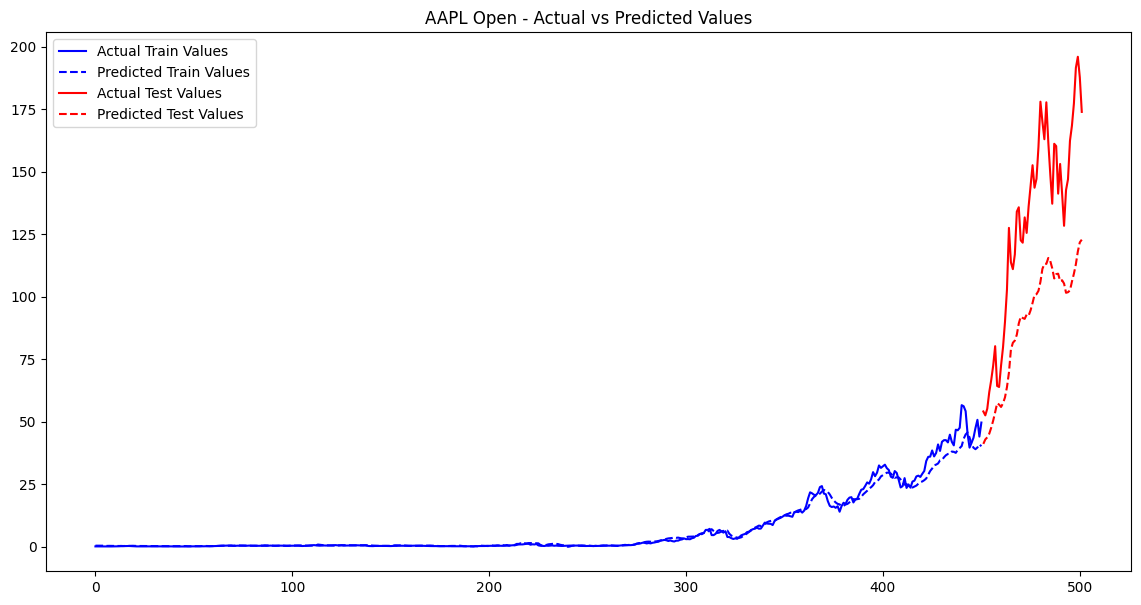


Evaluation for AAPL on High:
Training MAE: 0.9260569844898786, Testing MAE: 34.636538262460746
Training RMSE: 2.034001775209022, Testing RMSE: 38.18017706098558



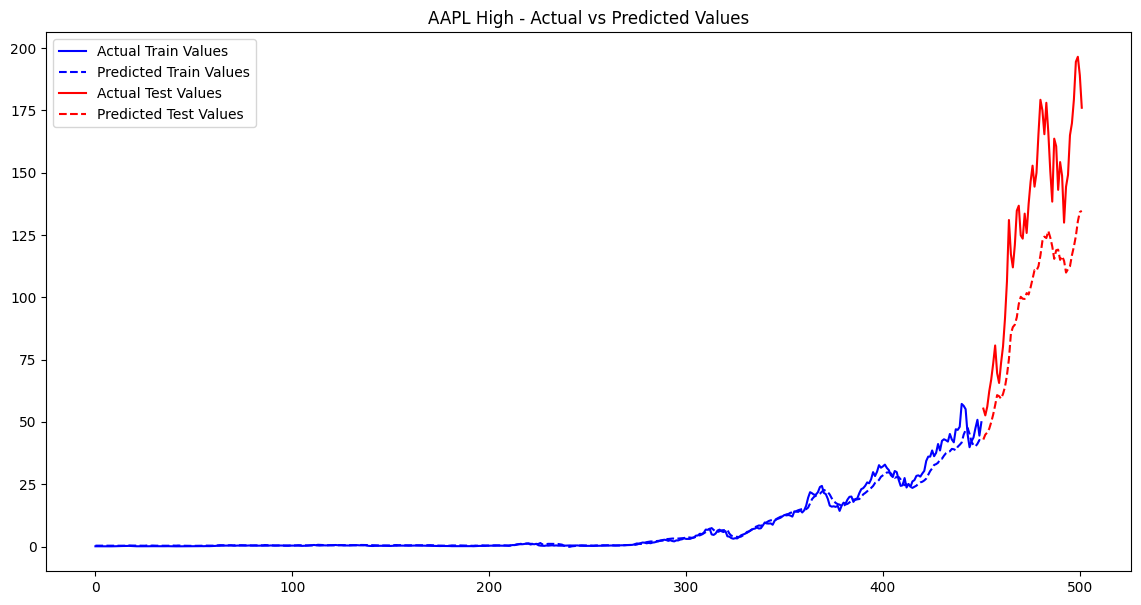


Evaluation for AAPL on Low:
Training MAE: 0.7814142409290813, Testing MAE: 16.868437673531325
Training RMSE: 1.599263907231037, Testing RMSE: 19.97828568039068



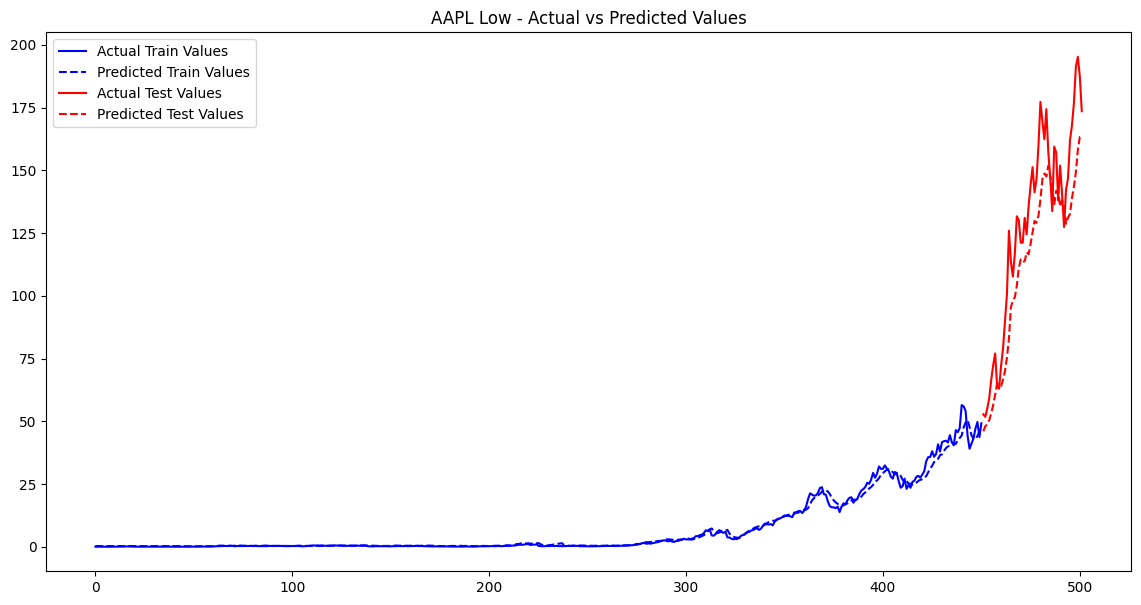


Evaluation for AAPL on Close:
Training MAE: 0.7391139996421839, Testing MAE: 11.447251338584753
Training RMSE: 1.5406203461779269, Testing RMSE: 14.316703308676688



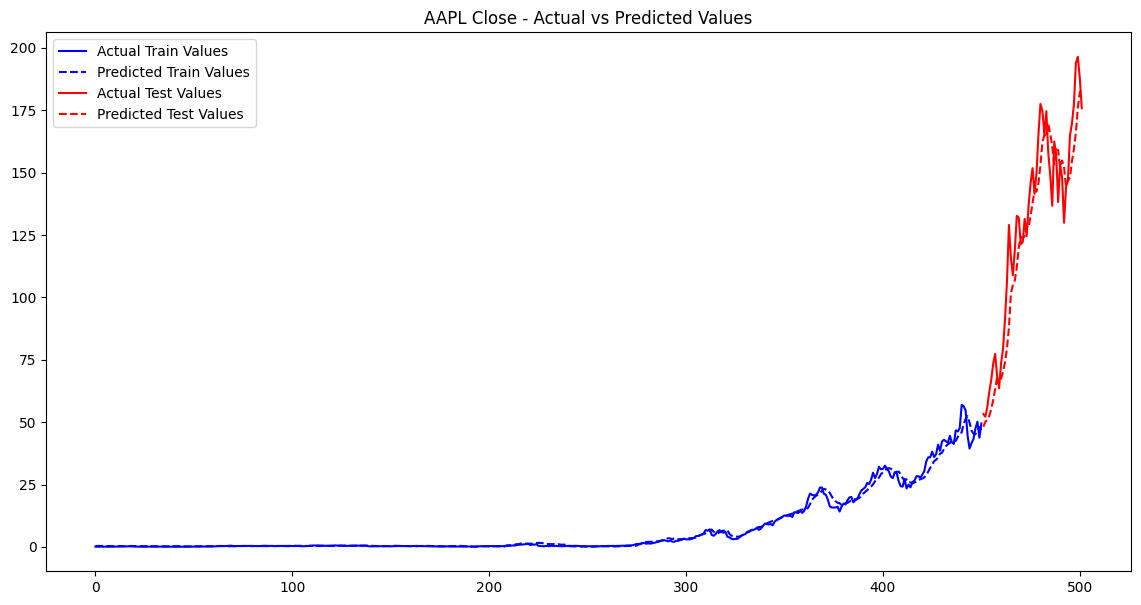


Evaluation for AAPL on Adj Close:
Training MAE: 0.7332923506983366, Testing MAE: 18.391362882127943
Training RMSE: 1.5633733303764892, Testing RMSE: 21.636413639021843



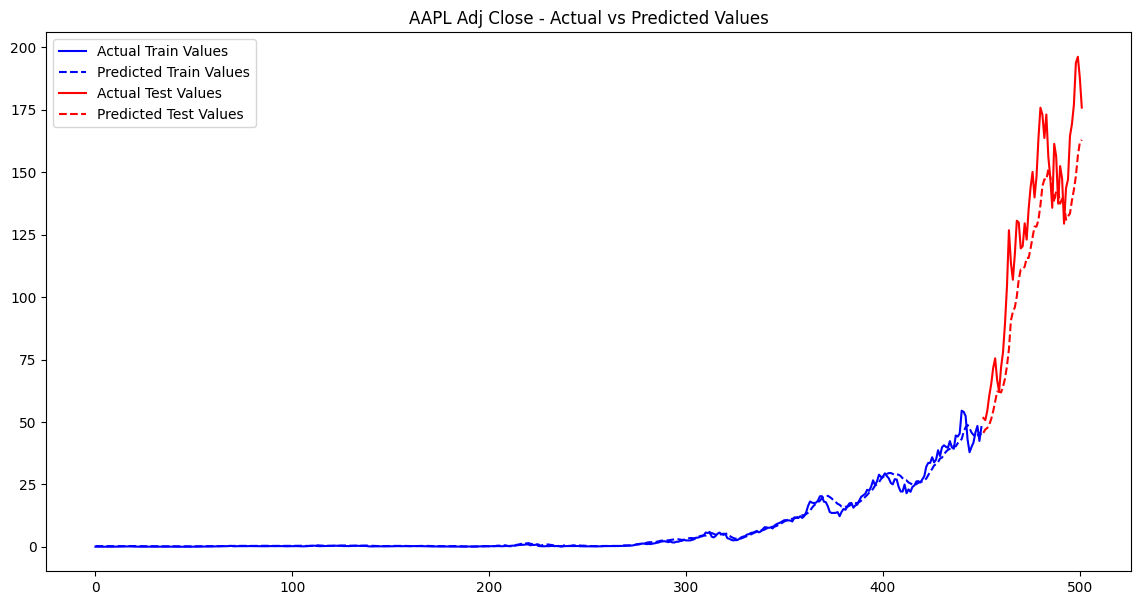


Evaluation for AAPL on Volume:
Training MAE: 150939940.54101995, Testing MAE: 1168166504.4117646
Training RMSE: 364157704.5740528, Testing RMSE: 1364662996.656598



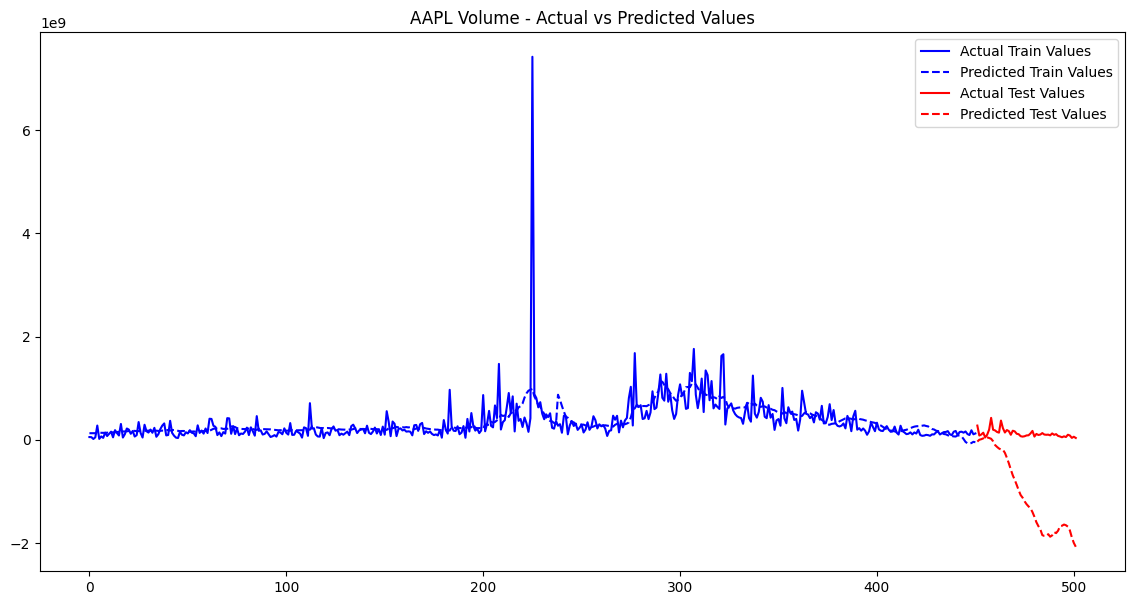

In [64]:
ticker = "AAPL"
data = all_data[ticker]

# Drop non-numeric columns
data = data.drop(columns=['Sector', 'Ticker', 'Date'])  # Assuming 'Date' is the index
lstm_model = LstmBuilder(time_step=time_steps, loss=huber_loss, neutrons=50)
model = lstm_model.create_model(features=features)
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)
X, y = lstm_model.create_sequences(normalized_data)
X_train, X_test, y_train, y_test = lstm_model.split_data(X,y, size=0.9)
print(len(X_train), len(X_test))
print()

print("Working on: " + ticker)  
model.fit(X_train, y_train, epochs=200, batch_size=16, validation_split=0.2, verbose=0)

# Predict the next day value
last_days = normalized_data[-time_steps:].reshape(1, time_steps, features)
prediction_next_day = model.predict(last_days)
prediction_next_day_actual = scaler.inverse_transform(prediction_next_day)
final_predictions[ticker] = prediction_next_day_actual.flatten()
print(f"Predicted value for {ticker}: {prediction_next_day_actual.flatten()}")


# Extracting importance
dense_weights = model.layers[-1].get_weights()[0]

# Think about to use sum or mean and to use abs() or not
feature_weights = dense_weights.sum(axis=0)
weighted_importance = prediction_next_day.flatten() * feature_weights
final_importance_value = np.sum(weighted_importance)  # Final importance as a single value
print(f"Importance value for {ticker}: {final_importance_value}")

# Store the importance value in the dictionary
final_importance_values[ticker] = final_importance_value

# Predict for both training and testing data
train_predictions = scaler.inverse_transform(model.predict(X_train))
test_predictions = scaler.inverse_transform(model.predict(X_test))
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)
features_list = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
for feature_index, feature_name in enumerate(features_list):
    # Extracting data for the specific feature
    y_train_feature = y_train[:, feature_index]
    y_test_feature = y_test[:, feature_index]
    train_predictions_feature = train_predictions[:, feature_index]
    test_predictions_feature = test_predictions[:, feature_index]

    # Evaluating the model for this feature
    evaluate_model(y_train_feature, train_predictions_feature, y_test_feature, test_predictions_feature, ticker, feature_name)

    # Plotting the results for this feature
    plot_predictions(y_train_feature, train_predictions_feature, y_test_feature, test_predictions_feature, ticker, feature_name)


In [60]:
final_importance_values

{'AAPL': -1.2869408}